
This notebook is a tutorial to apply deep learning techniques to tackle the multilabel classification problem given by Rakuten Institute of Technology for the 2021 edition of the [ENS Data Cahllenge](https://challengedata.ens.fr/). [Rakuten Multi-modal Colour Extraction](https://challengedata.ens.fr/challenges/59) is a challenge aiming at the prediction of color attribute of products (given their image, title, and description) from a large-scale multimodal (text and image) e-commerce product catalog data of Rakuten Ichiba marketplace. A product can be of multiple colors, making it a multi-label classification problem (with 19 possible colors).

We will only use the images for this tutorial, and build a Convolutional Neural Network to tackle this classification problem, relying on the [Pytorch](https://pytorch.org/) library developed by Facebook. More specifically, we will train a ResNet34 cnn model, that achieves an F1-weighted score of **0.635**. This is better than the benchmark for this challenge, which was obtained with a DenseNet121 model pretrained on ImageNet.

We will heavily rely on the **[Fastai](https://docs.fast.ai/)** software, "a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches". It is built on top of Pytorch. Although the code required to solve this problem is relatively small, I will try to explain some components of [Fastai v1](https://fastai1.fast.ai/) (we will be using the first version of the library), as well as some of the Deep Learning and computer vision techniques that have been used to obtain state-of-the-art results on previous Data vision competitions.

# Data preparation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.text import *

from sklearn.metrics import f1_score
import pandas as pd

import os
import matplotlib.pyplot as plt

In [3]:
path = Config.data_path()/'ens-rakuten-21'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/ens-rakuten-21')

In [4]:
path_image_train = path/'images/train'

In [5]:
dfin = pd.read_csv(path/'X_train_12tkObq.csv').rename(columns={'Unnamed: 0': 'ID'})
dfout = pd.read_csv(path/'y_train_Q9n2dCu.csv').rename(columns={'Unnamed: 0': 'ID'})

In [6]:
dfin.head()

,ID,image_file_name,item_name,item_caption
0,0,278003_10389968_1.jpg,三協アルミ M.シェード2 梁置きタイプ 片側支持 5818 H30 ポリカーボネート屋根 ...,商品番号19235601メーカー三協アルミサイズ幅 1931.0mm × 奥行き 5853....
1,1,220810_10010506_1.jpg,【40%OFF SALE/セール】30代〜40代 ファッション コーディネート 太サッシュ ...,太サッシュベルトで存在感アップ 柔軟性に優れた馬革を使用 幅が太めで存在感◎ キレイな形が出...
2,2,207456_10045549_1.jpg,下駄 桐 日本製 女性用 TONE 鼻緒巾が広め 黒塗り台 適合足サイズ 23〜24.5cm...,項目 桐の下駄 ※特別価格にて浴衣、半幅帯（浴衣帯）、巾着等も同時出品中です！ サイズ 下駄...
3,3,346541_10000214_1.jpg,＼期間限定【1000円OFF】クーポン 発行中／ シューズボックス 幅60 奥行33 15足...,■商品説明 ルーバーシューズボックス60幅のシングルタイプが登場。お部屋に合わせて色、サイズ...
4,4,240426_10024071_1.jpg,ポスト 郵便ポスト 郵便受け 集合住宅用ポスト 可変式プッシュ錠集合郵便受箱 PKS-M15...,集合住宅用ポスト 可変式プッシュ錠集合郵便受箱 PKS-M15-3 1列3段 暗証番号を自由...


In [7]:
dfout.head()

,ID,color_tags
0,0,"['Silver', 'Grey', 'Black']"
1,1,"['Brown', 'Black']"
2,2,"['White', 'Black']"
3,3,"['Beige', 'Brown', 'Black']"
4,4,['Silver']


In [8]:
dfout.color_tags.nunique()

8833

The training images are on disk, accessible via `path_image_train`, and their (color) labels are in the `dfout` dataframe. Before getting them through the model, we need to:
+ get the image files
+ split the data
+ label the data
+ turn the images into Tensors
+ apply transforms to the images
+ gather the data into mini-batches

Interestingly, we can do an important part of these operations without loading the images themselves into the RAM. Better yet, we should only have to grab the images we need for a specific mini-batch when we need it for the forward or the backward pass. For example, accessing the image files, splitting the data and labelling it can be done only with the paths to each image. And Fastai offers us exactly this possibility via the [Data block API](https://fastai1.fast.ai/data_block.html). The Data block API is one of the coolest features of Fastai, it offers separate methods with their own parameters for every choice that one needs to make in order to create and set up its data before feeding it to a neural network.

Let us show how to use it with our data. We will use the `ImageList` container, which is a Fastai class that is going to store the images paths, and provide us with a `__getitem__` method that loads the images from disk only when we need them. We can instantiate it with the folder path `path_image_train`. Then we will randomly split the data between a training set (90%) and a validation set (10%), operation that will be done on the images paths. And finally, we will label the images with a function, `label_from_df`, that will return the correct color tag given the image path.

In [9]:
labels = dfout.copy()
labels.color_tags = labels.color_tags.map(lambda s: s.replace("[", ""))
labels.color_tags = labels.color_tags.map(lambda s: s.replace("]", ""))
labels.color_tags = labels.color_tags.map(lambda s: s.replace("'", ""))
labels.color_tags = labels.color_tags.map(lambda s: s.replace(" ", ""))
labels.color_tags = labels.color_tags.map(lambda s: s.replace("MultipleColors", "Multiple Colors"))

labels = pd.merge(labels,dfin, how='left', 
                                left_on=['ID'], right_on=['ID'], 
                                suffixes = ['', '']).set_index('image_file_name')

def label_from_df(o):
    s = str(o)
    s = s.split('/')[-1]
    return labels.loc[s].color_tags

All this can be done with the few following lines:

In [10]:
def get_src(path, func, split_pct=0.1):
    
    return (ImageList.from_folder(path)
            .split_by_rand_pct(split_pct)
            .label_from_func(func, label_cls=MultiCategoryList, label_delim=","))

In [11]:
src = get_src(path_image_train, label_from_df)

Here we have the first image from the training dataset:

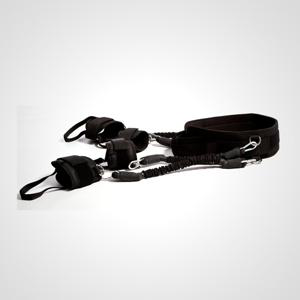

In [12]:
src.train[0][0]

and we have the first image from the validation dataset:

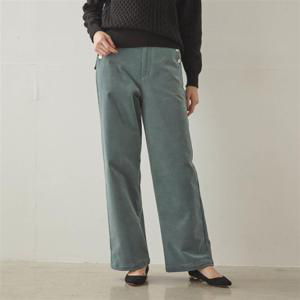

In [13]:
src.valid[0][0]

We can check that we have the right color attributes:

In [14]:
src.classes

['Beige',
 'Black',
 'Blue',
 'Brown',
 'Burgundy',
 'Gold',
 'Green',
 'Grey',
 'Khaki',
 'Multiple Colors',
 'Navy',
 'Orange',
 'Pink',
 'Purple',
 'Red',
 'Silver',
 'Transparent',
 'White',
 'Yellow']

At this stage, `src` contains two Pytorch `Datasets`, one for the training set and one for the validation set. The next step of our data preparation is to turn these `Datasets` into Pytorch `Dataloaders`, but before we do, we need to talk about Fastai **[transforms](https://fastai1.fast.ai/vision.transform.html)**.

## Data augmentation via image transformations

Data augmentation by image transformations is one of the most important regularization techniques in Computer Vision, and has become a standard procedure in winning strategies for Computer Vision competitions. During the training phase of the neural network, rather than grabbing the same images every time, we can apply to them small transformations (rotation, zoom, flip, warp, etc.) that do not affect their perception (their **visual** label) but do change their pixel values. This way, the neural network is less likely to overfit to the particular set of training images.

Fastai provides a complete image transformation library. The transformations are applied at the tensor level, every time we need to grab the images from disk, and with a user-defined probability `p` (often the same for all transformations). This way, these transformations are fast, they take zero disk-memory space, and they are different for every batch: a training image is almost never seen with the exact same characteristics by the network, giving the illusion of an *infinite* training data set. Since a picture is worth a thousand words, let us show how we they work on our dataset. We will use the Fastai `get_transforms()` function, that gives a set of transforms with defaults values that work pretty well (horizontal flip, rotation, zoom, lighting and contrast change and warp).

In [15]:
tfms = get_transforms()
size = 150
src.transform(tfms, size=size)

LabelLists;

Train: LabelList (190908 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
Black,White;Beige;Brown,White;Beige;Brown;Green,Black,Red;Beige;Silver;Gold;Grey;Blue;Black
Path: /home/jupyter/.fastai/data/ens-rakuten-21/images/train;

Valid: LabelList (21211 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
Grey;Blue,Khaki,Blue,Multiple Colors,Pink;Green;Black;Navy
Path: /home/jupyter/.fastai/data/ens-rakuten-21/images/train;

Test: None

Once this is done, we can check the third image of our training dataset.

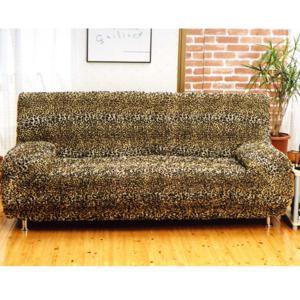

In [16]:
src.train.x[2]

Now every time we grab an image from `src.train`, a list of transformations is applied to it. We show this with the Fastai function `plot_multi`, that plots the result of calling some function for each of this row by column grid, and here the function just grabs the second image from the training set.

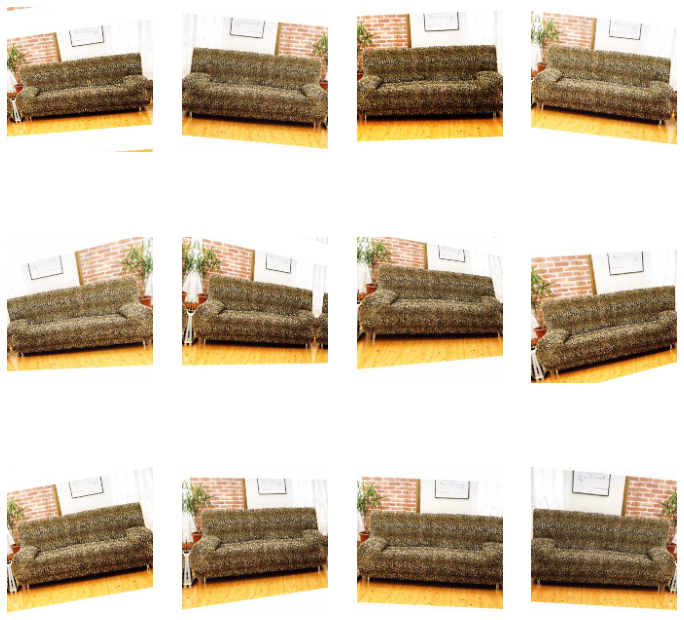

In [17]:
def _plot(i,j,ax): src.train[2][0].show(ax)
plot_multi(_plot, 3, 4, figsize=(12,12))

## Dataloaders and Databunch

Pytorch `Dataloaders` are Python iterators that make it easier to iterate over batches. They support automatic batching and **Random Sampling**, among other things. We will train our neural network with a variation of Stochastic Gradient Descent, and to this end we need to make sure that our model does not go through the training set in the same order for each epoch. Pytorch `RandomSampler` class helps us achieve just that, and we can pass `shuffle=True` to our training `Dataloader` when we instantiate it, and it will use the default random sampler of Pytorch. 

In order to speed up our calculations, we are going to use a GPU, which means that we have to pop the model's parameters, inputs and targets every time we do a forward or backward pass. We can have access to our GPU via `torch.device`, and Fastai `Databunch`is wrapper around a `Dataloader` and a (cuda) `torch.device` that binds them together. More specifically, the `Databunch` will bind together a training `Dataloader`, a validation `Dataloader` and a `torch.device` into a data object. We create our `Databunch` from our `src` datasets, and we give it a batch size `bs` for the training phase. Since the validation calculation does not invovle a backward pass, we can use twice the training batch size for it. Finally, we will start with a Resnet34 model pretrained on Imagenet, so we have to normalize our images with the Imagenet statistics. And this concludes our data preparation phase.

In [18]:
bs = 32
data = (src.databunch(bs=bs, val_bs=bs*2).normalize(imagenet_stats))

In [19]:
data

ImageDataBunch;

Train: LabelList (190908 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
Black,White;Beige;Brown,White;Beige;Brown;Green,Black,Red;Beige;Silver;Gold;Grey;Blue;Black
Path: /home/jupyter/.fastai/data/ens-rakuten-21/images/train;

Valid: LabelList (21211 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
Grey;Blue,Khaki,Blue,Multiple Colors,Pink;Green;Black;Navy
Path: /home/jupyter/.fastai/data/ens-rakuten-21/images/train;

Test: None

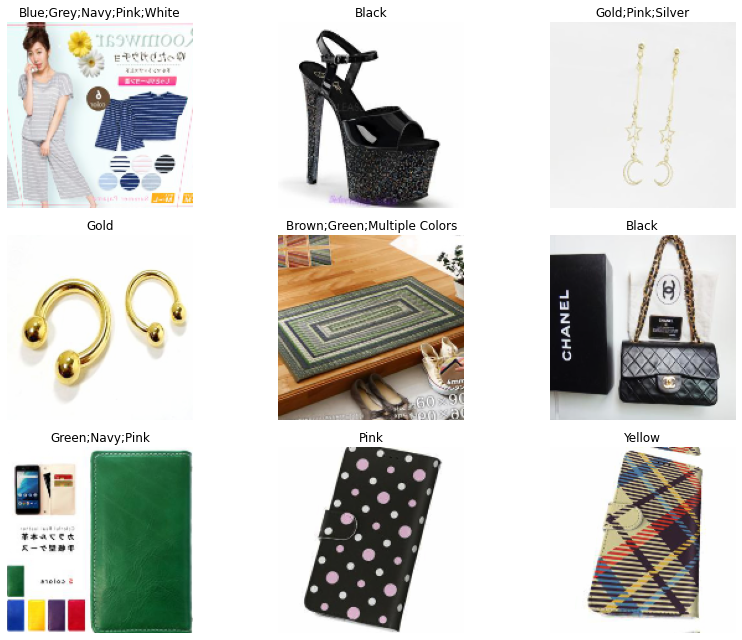

In [29]:
data.show_batch(rows=3, figsize=(12,9))

In [20]:
# data.save('rz-150')

In [26]:
# data = load_data(path_sample, 'rz-150', bs=bs)

# Model training

Now that we have our data, we can start the model training phase. We will use a pretrained Resnet34 model, and create a `Learner` Fastai object by calling the `cnn_learner` function. This function binds together a `Databunch` object, and a CNN model architecture. Then it will cut the CNN architecture after the last convolutional layer, and add a special *head* to the neural network model, with essentially blocks of Batchnorm, Dropout, Linear and ReLU layers, where the size of the last output will of course be the number of classes of our classification problem. We make sure that the base CNN model is pretrained on ImageNet by specifying `pretrained=True` in the arguments of the `cnn_learner` function (this is the default value by the way). 

We can add metrics to our `Learner` object to monitor our training. Here, we use a specific accuracy metric adapted to multilabel classification problems, and an F1 score.

In [21]:
acc_ = partial(accuracy_thresh, thresh=0.5, sigmoid=True)
f_score = partial(fbeta, thresh=0.5, beta=1, sigmoid=True)

After every epoch, our `Learner` object will compute the metrics of our model on the validation set, and print them out.

In [22]:
arch = models.resnet34
img_learner = cnn_learner(data, arch, metrics=[acc_, f_score])

Before we start with the training loop, a quick word regarding the optimizer. We use the (pretty standard now) Adam optimizer, implemented natively in Pytorch, with a default value of `0.9` for the parameter of the exponentially weighted moving average of the gradients, and a default value of `0.99` for the gradients squared. All of this is done by Fastai by default when we instantiate a `Learner` object, so we do not have to worry about it. If you want more informations regarding this optimizer, you can refer to its introduction paper, [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980).

We are ready to train our neural network, and the first thing we have to do is to set a learning rate.

## Learning Rate Finder

One of the most important things to do when training a deep neural network is to set a good learning rate. If the learning rate is too low, the training phase will take a lot of time, resulting in a waste of resources and an increased chance for the network to overfit, because we need a lot of epochs. On the other hand, a high learning rate can make the model parameters diverge. In the paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186), researcher Leslie Smith came up with a very good and very simple idea to find a good learning rate: we set a really low learning rate, and calculate the loss with one mini-batch; from then we progressively increase the learning rate, grab a new mini-batch and calculate a new value for the loss; we repeat until the loss explodes. Most of the time, the loss plot against the learning rate should behave like this: at the beginning the plot is almost a constant, it then rapidly decreases until a minimum point and then starts exploding exponentially. We want to choose a learning rate that corresponds to the steepest decrease in the loss. This can be done easily in Fastai with the two following lines of code:

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


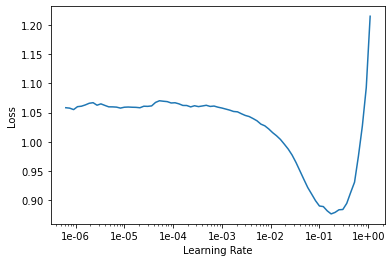

In [27]:
img_learner.lr_find()
img_learner.recorder.plot()

We see that something between *1e-2* and *5e-2* will be a good candidate for the first part of our training.

## One-cycle Scheduler

Next we need to fit our model to the data. Instead of using the same (carefully chosen) learning rate for all mini-batches, we will make it vary. Leslie Smith (him again!), in the paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186), showed that it was actually beneficial to start with a small learning rate, increase it to the maximum value obtained by the LR Finder, and then decreasing it again towards the end of training. One reason that justifies this strategy is the following: the loss surface, that depends on the model parameters values, changes during training; so it is very unlikely that the same learning rate will be good for every part of the training. This strategy is implemented in the Fastai library, and we can access it directly with our `Learner` object with the method `fit_one_cycle`, that takes as arguments the number of epochs and the maximum learning rate.

In [28]:
lr = 1e-2
img_learner.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.242684,0.229155,0.913796,0.402556,13:16
1,0.227748,0.218380,0.917268,0.449582,04:23


We only did two epochs to show the evolution of the learning rate and the (first order) momentum parameter with the number of iterations. They evolve in opposite directions, which makes sense because with a low learning rate, you want to speed up convergence with a high momentum, and with a high learning rate, you want to avoid overshooting when updating the model parameters with a low momentum. Thus the following evolution of these two optimization parameters.

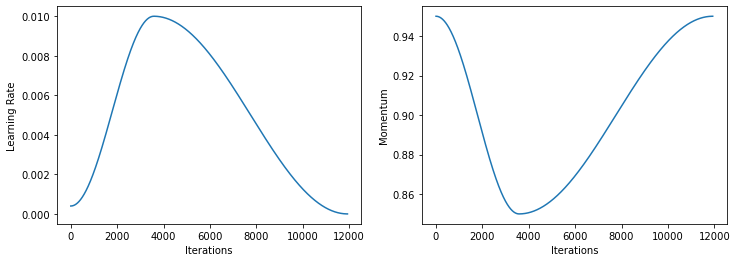

In [30]:
img_learner.recorder.plot_lr(show_moms=True)

Let us train for a lot more epochs.

In [23]:
lr = 1e-2
img_learner.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.243164,0.234886,0.911538,0.382575,13:01
1,0.245011,0.232125,0.913272,0.368206,06:06
2,0.242960,0.231256,0.912979,0.414451,06:05
3,0.244118,0.865612,0.912452,0.452564,06:07
4,0.238333,0.237875,0.912560,0.446464,06:04
5,0.232396,0.224931,0.916684,0.465870,06:05
6,0.222513,0.250062,0.916699,0.453673,06:07
7,0.226832,0.221871,0.917893,0.449462,06:07
8,0.225644,0.213638,0.919302,0.468682,06:10
9,0.218841,0.228729,0.918786,0.472794,06:09


We will create our own metric to obtain the same weighted F1-score as the one used in the competition.

In [29]:
def f1s(learner, thresh=0.5, sigmoid=False):
    y_pred, y_true = learner.get_preds(ds_type=DatasetType.Valid)
    if  sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh)
    return f1_score(y_true, y_pred, average='weighted')

In [25]:
f1s(img_learner)

0.46917328043953427

We then try different threshold values to try and find the good one for our particular dataset.

In [26]:
thresh_ls = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresh_ls:
    print(f1s(img_learner, thresh=thresh))

0.4920998567798323


0.5534761871908143


0.554561075197716


0.5227864363949271


0.46917328043953427


*0.3* seems to be a good candidate! It is time to talk about **gradual unfreezing**.

In [27]:
# img_learner.save('stage-1-rn34-rz')

In [ ]:
# img_learner.load('stage-1-rn34-rz')

## Gradual unfreezing

The architecture of the Resnet34 (and that of many modern cnn for that matter) consists of many convolutional layers, followed at the end by a few linear layers and nonlinear activations, with the last linear layer adapted to the number of classes of the task at hand. We will call the convolutional part the *body* of the model, and the linear part the *head* of the model. This means that our model can be divided into *layers groups*, at least two, and even more if we differentiate the layers in the body part. When we use a pretrained Resnet, we keep its body, and replace its head with new linear and nonlinear activations whose weights are randomly initialized. However, this new model is not completely random, since its body weights have been trained to be good at image classification tasks. More specifically, the layers closer to the inputs are good at extracting relevant features from images. In order to fully benefit from *transfer learning*, it is then a good idea to keep the body weights of our model, and only train the (randomly initialized) head weights at first. Then, we train the body weights (gradually among the body layers groups if necessary). This strategy, consisting in first *freezing* some weights of our model, and then *unfreezing* them in successive steps of our training procedure is called **gradual unfreezing**. It is very effective, and very easy to implement in Fastai. When we create our `Learner` object with a pretrained architecture, Fastai automatically freezes the body part of the model. To unfreeze it, we just have to use the `unfreeze` method of the `Learner` object.

In [31]:
img_learner.unfreeze()

## Discriminative learning rates

It was shown in the paper [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901) that in a CNN, the first layers learn rather general image features, like corners and edges, and as we ascend the layers, the learned features are more and more complex, and the network start to identify faces for example. This suggests that when tackling our image classisfication task with a pretrained Resnet, we should not modify the first layers weights to the same extent as the last layers weights, since the first one have captured features that are highly transferable to our problem. A good way to achieve this is **discriminative learning rates**: we use different learning rates for different layers at different depths. So after unfreezing our network, we first set the first layer group learning rate with the LR Finder:

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


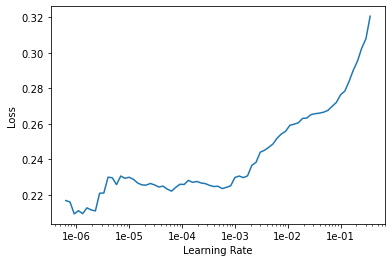

In [32]:
img_learner.lr_find()
img_learner.recorder.plot()

Here, we want to choose a value that is one or two order of magnitudes lower than the value at which the loss starts to explode. *1e-5* is a good choice. Then for the last layer group, the one that we trained before, we choose something a little bit lower than the initial maximum learning rate, so this value divided by 5 for example. Then when we pass `slice(low_lr, high_lr)` to the `fit_one_cycle` method of our `Learner`. Fastai automatically allocates `low_lr` to the first layers group, `high_lr` to the model’s head and equally spaced learning rate values in between.

In [33]:
img_learner.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.215641,0.937980,0.915109,0.463781,06:58
1,0.225716,0.219362,0.919247,0.466863,07:00
2,0.218106,0.550244,0.917729,0.462608,07:00
3,0.211350,0.207856,0.922515,0.527926,07:00
4,0.209553,0.205028,0.923821,0.505861,07:00
5,0.201430,0.295682,0.924156,0.535833,07:00
6,0.191378,0.197802,0.926793,0.544312,07:01
7,0.191507,0.193737,0.927935,0.560990,07:02
8,0.185896,0.534788,0.926910,0.564123,07:02
9,0.173168,0.287014,0.927771,0.567645,07:00


In [35]:
thresh_ls = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresh_ls:
    print(f1s(img_learner, thresh=thresh))

0.5505927457308568


0.6081182765058023


0.6186544556869153


0.6060043913798625


0.5746876971334307


Clearly, this is pretty effective!

## Progressive resizing

The last technique that we are going to implement is called **progressive resizing**, and it can be described like this: start by training your network with low-resolution versions of your images; then progressively increase the resolution of your images, and train your network for more epochs. This simple idea has a lot of benefits:

+ since we are changing the image resolution, from the network point of view, we end up with different pixel values for the same picture, so the resizing acts as a form of data augmentation that helps the model generalize better
+ even though low-resolution and high-resolution images are different, they are still very similar (at least to the human eye), so that our network trained on low-resolution image can *transfer* the knowledge it acquired to the high-resolution images classification: yes, there is *transfer learning* right here!
+ finally, this helps training complete faster, thanks to the small images size in the beginning of training

In [38]:
# img_learner.save('stage-2-rn34-rz')

In [33]:
# img_learner.load('stage-2-rn34-rz')

You probably noticed that when we created the first `Databunch`, we used a `size` argument for the `transform` method, and we set it to *150*. The size of our original images is *300x300* pixels; so by setting the size to *150*, we asked Fastai to decrease the images size to *150x150* pixels before feeding them to the network. So now to implement progressive resizing and train the network to the maximum resolution of the images, we just have to create a new `Databunch` with `size=300`.

In [39]:
size = 300
data = (src.transform(tfms, size=size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [38]:
# data.save('rz-300')

In [26]:
# data = load_data(path_sample, 'rz-300', bs=bs)

Next, we change the `data` attribute of our learner. From then, we now have a pretrained Resnet34 model, with a *new* dataset, and we want to implement image classification. We are back to square one of our training procedure, but with a much better pretrained model, and we can implement all the tricks that we described earlier. We just have to `freeze()` our learner, in order to implement gradual unfreezing.

In [27]:
img_learner.data = data
img_learner.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


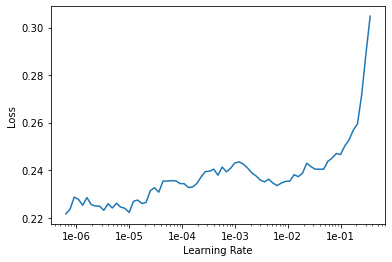

In [31]:
img_learner.lr_find()
img_learner.recorder.plot()

In [32]:
lr = 1e-3
img_learner.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.208901,0.958095,0.919662,0.504495,16:53
1,0.204569,0.348959,0.922414,0.510942,11:44
2,0.197722,0.210893,0.925004,0.538282,11:44
3,0.195589,0.402131,0.924974,0.540459,11:44
4,0.190928,0.252322,0.924932,0.542048,11:44
5,0.201536,0.335816,0.924031,0.550605,11:44
6,0.199087,0.223745,0.925865,0.550274,11:45
7,0.201042,0.203933,0.926250,0.549293,11:45
8,0.194438,0.202262,0.926185,0.540655,11:44
9,0.196862,0.218351,0.926262,0.544855,11:44


In [35]:
f1s(img_learner)

0.5497991199414785

In [36]:
thresh_ls = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresh_ls:
    print(f1s(img_learner, thresh=thresh))

0.5290065397376693


0.5927616693723778


0.6037824868328262


0.5867605246477562


0.5497991199414785


In [39]:
img_learner.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


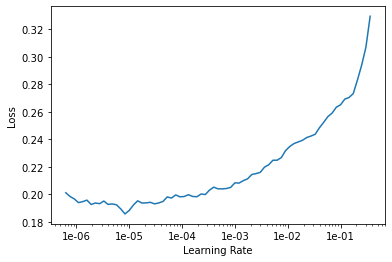

In [40]:
img_learner.lr_find()
img_learner.recorder.plot()

In [41]:
img_learner.fit_one_cycle(10, slice(5e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.185736,0.216014,0.926731,0.561554,16:56
1,0.194323,0.302756,0.926374,0.555981,16:57
2,0.203803,0.198902,0.926716,0.546700,16:57
3,0.190149,0.198088,0.927557,0.558579,16:57
4,0.192751,0.312239,0.927599,0.563870,16:58
5,0.179090,0.190919,0.929562,0.576601,16:58
6,0.173403,0.199290,0.930305,0.592788,16:58
7,0.172541,0.189239,0.931438,0.597929,16:58
8,0.166537,0.189852,0.931967,0.597187,16:58
9,0.159158,0.187607,0.931932,0.596937,16:59


In [43]:
f1s(img_learner)

0.6031189497966506

In [44]:
thresh_ls = [0.1, 0.2, 0.3, 0.4, 0.5]
for thresh in thresh_ls:
    print(f1s(img_learner, thresh=thresh))

0.5724102194355511


0.6282515619008742


0.6373847511327037


0.6273846435088171


0.6031189497966506


# Submission file

## Load test dataset

We can easily add the test images to our `Learner`, with the `add_test()` method of its `Databunch`.

In [4]:
path_image_test = path/'images/test'
path_image_test.mkdir(parents=True, exist_ok=True)

In [46]:
test_il = ImageList.from_folder(path_image_test)
test_il

ImageList (37347 items)
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
Path: /home/jupyter/.fastai/data/ens-rakuten-21/images/test

In [47]:
img_learner.data.add_test(test_il)

In [56]:
preds, _ = img_learner.get_preds(ds_type=DatasetType.Test)

In [57]:
thresh = 0.3
labelled_preds = [', '.join(["'"+img_learner.data.classes[i].lstrip()+"'" for i,p in enumerate(pred) if p >= thresh]) for pred in preds]

In [58]:
labelled_preds[:5]

["'White'",
 "'Black', 'White'",
 "'Blue', 'Green', 'Navy', 'Purple', 'Red', 'Yellow'",
 "'Green'",
 "'Black'"]

In [59]:
preds_sub = ['['+o+']' for o in labelled_preds]

In [60]:
preds_sub[:5]

["['White']",
 "['Black', 'White']",
 "['Blue', 'Green', 'Navy', 'Purple', 'Red', 'Yellow']",
 "['Green']",
 "['Black']"]

In [66]:
fnames = [f.name for f in img_learner.data.test_ds.items]

In [76]:
dfsub = pd.DataFrame({'image_file_name':fnames, 'color_tags':preds_sub}, columns=['image_file_name', 'color_tags'])

In [77]:
dfsub.head()

,image_file_name,color_tags
0,308127_10023263_1.jpg,['White']
1,316804_10001537_1.jpg,"['Black', 'White']"
2,303653_10020308_1.jpg,"['Blue', 'Green', 'Navy', 'Purple', 'Red', 'Ye..."
3,301860_10004624_1.jpg,['Green']
4,200250_10031024_1.jpg,['Black']


We have to make sure that our result dataframe is written in the same order for the images filenames as the test csv file.

In [78]:
dftest = pd.read_csv(path/'X_test_gDTIJPh.csv').rename(columns={'Unnamed: 0': 'ID'})
dftest.head()

,ID,image_file_name,item_name,item_caption
0,0,295152_23116034_1.jpg,KYV39 miraie f ミライエ フォルテ kyv39 au エーユー スマホ ケース...,注意事項 素材ケースの入荷時期により、商品写真とは一部カメラ・ボタン穴などの形状が異なるケー...
1,1,295152_26516148_1.jpg,SO-04K Xperia XZ2 Premium エクスペリア エックスゼットツー プレミ...,注意事項素材ケースの入荷時期により、商品写真とは一部カメラ・ボタン穴などの形状が異なるケース...
2,2,295152_24772914_1.jpg,MO-01K MONO モノ mo01k docomo ドコモ 手帳型 スマホ カバー カバ...,商品特徴 ・シームレスな全面デザイン（内側は落ち着いたオフホワイト） ・外側は高品質の人工革...
3,3,284888_11730362_1.jpg,Xperia XZ 手帳型ケース ビーチ ハワイ エクスペリア ケース カバー ケイオー ブ...,対応機種Xperia XZ ( エクスペリア ) ソニー対応型番XperiaXZキャリアDo...
4,4,245178_17489104_1.jpg,【中古】コムサデモード COMME CA DU MODE スカート ボムトス ロング丈 斜め...,【中古】コムサデモード COMME CA DU MODE スカート ボムトス ロング丈 斜め...


In [79]:
dft = dftest.copy()
del dft['ID']
del dft['item_name']
del dft['item_caption']

In [80]:
dfsub.set_index('image_file_name', inplace=True)
dft.set_index('image_file_name', inplace=True)
dfsub = pd.merge(dft, dfsub, how='left', 
                                left_on=['image_file_name'], right_on=['image_file_name'], 
                                suffixes = ['', '']).reset_index()

In [81]:
dfsub.reset_index(inplace=True)
del dfsub['image_file_name']
dfsub.head()

,index,color_tags
0,0,"['Beige', 'Pink']"
1,1,['Black']
2,2,[]
3,3,['Navy']
4,4,['Grey']


In [82]:
dfsub.rename(columns={"index": "ID"}).to_csv('submission.csv', index=False)

# Concluding remarks

In this notebook, we did no exploration data analysis at all. Let us do some little counting.

In [6]:
dfout['count'] = dfout.groupby('color_tags')['color_tags'].transform('count')

In [14]:
uniq = dfout.color_tags.nunique()
uniq

8833

In [8]:
n = 10
dfout['count'].value_counts()[:n].index.tolist()

[28308, 16408, 11465, 11463, 7562, 7041, 6500, 6212, 5734, 5654]

In [9]:
dfout[dfout['count']>=5654].groupby('color_tags').size()

color_tags
['Beige']              5734
['Black']             28308
['Blue']              11465
['Brown']             11463
['Green']              6212
['Grey']               7041
['Pink']               7562
['Red']                6500
['White', 'Black']     5654
['White']             16408
dtype: int64

In [12]:
count10 = dfout[dfout['count']>=5654].groupby('color_tags').size().sum()
count10

106347

In [13]:
count10 / len(dfout) * 100

50.13530077314727

In [15]:
n / uniq * 100

0.11321181931393638

We see that *0.11%* of the unique (multi-)labels account for half of our dataset! This is an acute data imbalance, and since the test set probably shares this distribution, we can almost certainly improve our results by addressing this issue.